<a href="https://colab.research.google.com/github/Vixuz144/Simu2/blob/main/Robin_Hood_Radios_Uniformes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Simulación

1. El primer paso es definir las variables que intervienen en el problema.

Para ello, se desarrollarán las variables en coordenadas polares para luego transformarlas a coordenadas polares.

* $Θ ∼ Exp[λ]$
* $R ∼ U[0,\mathcal{R}]$

donde $\mathcal{R}$ es el radio de un circulo dentro del cual se generarán las posiciones de los árboles y $λ$ es el parámetro del proceso de Poisson, lo cual para nuestro contexto será la densidad de árboles en el bosque de Sherwood (ρ).

A partir de ambos parámetros es que se generará el proceso de Poisson que expresa la ubicación de los árboles del bosque de Sherwood.

Además, se considerará una distribución uniforme en $[0,2]$ para los radios de los árboles.

* $r_a ∼ U(0, 2) $

2. En adición, las funcioness de distribución de probabilida de estas tres variables son:

$$ f_Θ(θ) = λe^{-λθ}, \quad \textrm{para } θ \geq 0, \ θ\in\mathbb{R} $$
$$ f_R(r) = \frac{1}{\mathcal{R}}, \quad \textrm{para } r \in [0, \mathcal{R}], \ r\in\mathbb{R} $$
$$ f_{r_a}(x) = \frac{1}{2}, \quad \textrm{para } x \in [0, 2], \ x\in\mathbb{R} $$



3. Y las funciones de distribución acumulada de estas variables son:



$$ F_Θ(θ) = 1 - e^{-λθ}, \quad \textrm{para } θ \geq 0, \ θ\in\mathbb{R} $$
$$ F_R(r) = \frac{r}{\mathcal{R}}, \quad \textrm{para } r \in [0, \mathcal{R}], \ r\in\mathbb{R} $$
$$ F_{r_a}(x) = \frac{x}{2}, \quad \textrm{para } x \in [0, 2], \ x\in\mathbb{R} $$

3. Con todo esto, podemos pasar a generar los árboles. Para lo cual haremos uso de la siguiente función.

In [ ]:
from random import random
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from numba import jit

In [ ]:
@jit(nopython = True)
def bosque(r, ρ):
  n = 0
  X = []
  while sum(X) <= np.pi*r**2:
    n += 1
    X.append(-np.log(random())/ρ)

  R, θ = [], []
  i = 1
  while n>1 and i<n:
    R.append(np.sqrt(sum(X[:i])/np.pi))
    θ.append(2*np.pi*random())
    i += 1

  return R, θ

Esta función genera el proceso de Poisson bivariado.

* Entradas:
  * r: radio del circulo dentro del cual se generarán los arboles. Debe ser positivo.
  * ρ: parámetro del proceso de Poisson (λ). Densidad media de arboles en el bosque de Sherwood. Debe ser positivo.


* Salidas:
  * X: lista con las abscisas de las coordenadas de los arboles.
  * Y: lista con las ordenadas de las coordenadas de los arboles.

Además,para generar los radios de los árboles, usaremos la siguiente función.

In [ ]:
@jit(nopython = True)
def radios_unif(n, a = 0, b = 2):
  return a + (b-a) * np.random.random(n)

Esta función genera una array de radios con distribución normal,truncada o acotada a valores positivos de radios.
* Entradas:
  * n: cantidad de números aleatorios a generar, cantidad de árboles.
  * a: límte inferior del intervalo para generar números aleatorios, el rádio más pequeño que se puede obtener.
  * b: límte superior del intervalo para generar números aleatorios, el rádio más grande que se puede obtener.
* Salidas:
  * r_a: Lista de los radios de los árboles con distribución uniforme.

4. Ahora, veamos la ejecución de la función. Para ello consideraremos un radio de $100m$ y una densidad de $0.005\frac{árboles}{m^2}$ para nuestra simulación.

In [ ]:
radio = 100
densidad = 0.005

In [ ]:
R, θ = bosque(radio, densidad)
X = R*np.cos(θ)
Y = R*np.sin(θ)

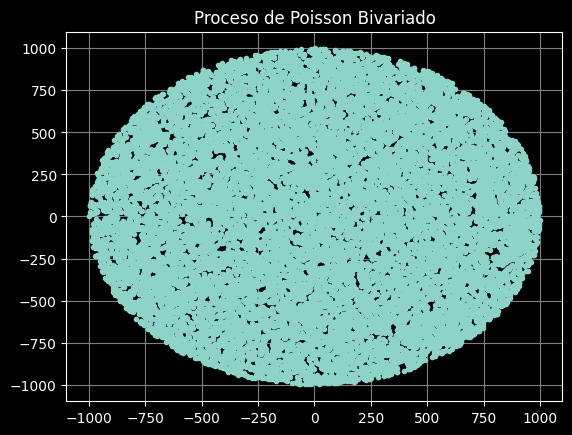

In [ ]:
plt.style.use('dark_background')
plt.plot(X,Y, '.')
plt.title('Proceso de Poisson Bivariado')
plt.grid(color='gray')
plt.show()

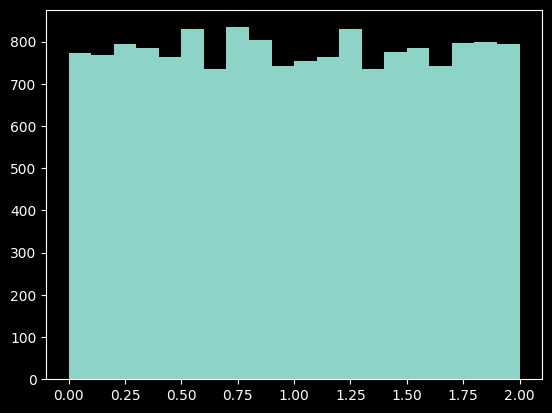

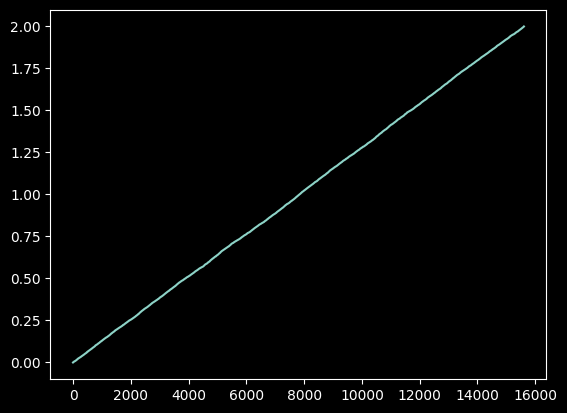

In [ ]:
l = radios_unif(len(X))
plt.hist(l, bins = 20)
plt.show()

plt.plot(np.sort(l))
plt.show()

5. Implementación del arquero, Robin Hood.

Para esste punto, ya tenemos la una pequeña parte de nuestra simulación armada. Ahora, vamos a agregar a nuestro coprotagonista del problema, Robin Hood. Para ello vamos a considerar que este famoso arquero se localiza en el centro de nuestro bosque de Sherwood. Y al lanzar una flecha en una dirección (cartesiana) aleatoria podrá impactarse y quedar fija en algún arbol. Ahora la dilemática está en ¿Cómo sabremos que la flecha queda incrustada o no en el árbol?.

Para ello tendremos que saber que dimensiones tiene el arbol. Para lo cual consideremos de momento que el tronco del arbol es un cilindro de radio $r_a$. Con lo cual si la dirección de la flecha se intersecta con una circunferencia de radio $r_a$ con centro en las cordenadas de un árbol, habrá impactado con el árbol y diremos que ahí fue donde terminó la fleca tras el lanzamiento.

Para programar esto, haremos uso de pequeños trucos Para ahorrar recursos computacionales.
* Primero, en lugar de disparar una flecha en una dirección aleatoria vamos a dispararla en la dirección del eje positivo $x$, es decir, con dirección $(1, 0)$. esto ya que al generar un bosque aleatorio cada vez, será como haber elegido una dirección por la misma pseudo-aleatoriedad del proceso de Poisson.
* Con ésta implementación ahora solo queda decidir cuando la flecha ha impactado con el arbol. Para lo cual descartaremos todos los arboles que tengan coordenadas negativas en su abscisa. Ya que no podrá llegar la flecha en esa dirección a menos que rebote.
* Luego, en lugar de calcular la circunferencia de cada uno de los árboles, unicamente comprobaremos si la flecha pasa sí suficientemente cerca de los árboles. Para ello compararemos el radio de cada árbol en la media circunferencia con la distancia que hay del centro del árbol (coordenadas generadas por el proceso de Poisson) a la flecha, de manera que si la distancia es menor al radio la flecha habrá impactado, y en caso de que la distancia sea mayor al radio la flecha no habrá impactado.
* Y el truquito final será como calcular la distancia del centro del árbol a la flecha, el cual será fácil gracias a tomar la dirección de la flecha como el eje $x$ positivo. Ya que se despreciará la coordenada en $x$ del árbol y de la flecha, resultando en que la distancia será el valor absoluto de la coordenada en $y$ del árbol.

Lo único que resta antes de codificar estos trucos será considerar que la flecha se detiene cuando impacte el primer árbol. Por lo cual Robin deberá ir por su fleha hasta ese árbol en caso de querer recuperarla.

In [ ]:
@jit(nopython = True)
def disparo_flecha(X, Y, R, max_dist):
  n = len(X)

  pos = np.equal(X>0, True*np.ones(n))
  X_pos, Y_pos, R_pos = X[pos], Y[pos], R[pos]

  s = np.argsort(X_pos)
  X, Y, R = X_pos[s], Y_pos[s], R_pos[s]
  n = len(Y)

  x, y, r = 0, 0, 0
  for i in range(n):
    if abs(Y[i]) <= R[i]:
      x, y, r = X[i], Y[i], R[i]
      break
  if x != 0 or y!= 0:
    d = x - np.sqrt(r**2 - y**2)
  else:
    d = max_dist
  return x, y, d

La función *disparo_flecha* simula el disparo de la flecha de Robin Hood, considerando los "trucos" antes mencionados.
* Entradas:
  * X: lista de abscisas de las coordenadas de los árboles.
  * Y: lista de ordenadas de las coordenadas de los árboles.
  * R: lista de los radios de los árboles.
  * max_dist: Máxima distancia que recorrerá el tiro o radio del bosque.
* Salidas
  * x: abscisa del arbol enque impactó la flecha.
  * y: ordenada del arbol enque impactó la flecha.
  * d: distancia que recorrió la flecha hasta impactar con la cortesa árbol.

La flecha impactó en el arbol con coordenadas (34.666981577221264,0.09285938565713489). La flecha recorrió 34.170931093511705m


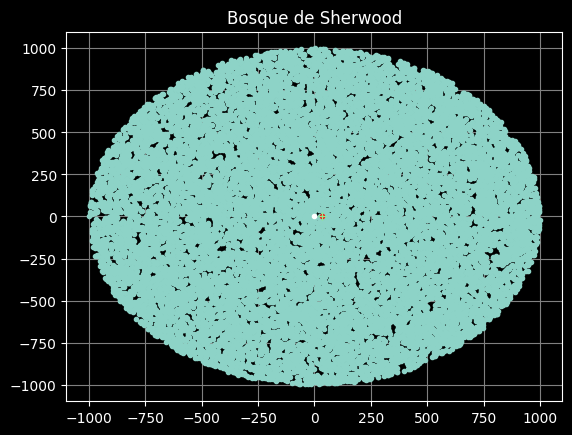

In [ ]:
r_a = radios_unif(len(X))
x, y, d = disparo_flecha(X, Y, r_a, radio)

print(f'La flecha impactó en el arbol con coordenadas ({x},{y}). La flecha recorrió {d}m')

plt.plot(X, Y, '.')
plt.plot(0, 0, '.w')
plt.plot(x, y, '.r')
plt.plot(d, 0, '+', color = 'lightgreen')
# plt.xlim(-x-10, x+10)
# plt.ylim(-x-10, x+10)
plt.title('Bosque de Sherwood')
plt.grid(color='gray')
plt.show()

6. Ya que tenemos la simulación de un tiro, solo queda repetir los tiros varias veces para poder observar el comportamiento del proceso. De manera que podamos llegar al estado estable de la simulación. Para ello es que usaremos la siguiente función.

In [ ]:
def experimento(R, ρ, r_dist, n = 10**4):
  l = []
  for i in range(n):
    r, t = bosque(R, ρ)
    x = r*np.cos(t)
    y = r*np.sin(t)
    try:
      m, s = r_dist
    except:
      m = 0
      s = r_dist
    lr = radios_unif(len(x), m, s)
    _, _, d = disparo_flecha(x, y, lr, R)
    l.append(d)
  return l

In [ ]:
radio = 320
densidad = 0.005
rd = (0,2)
n = 10**5

In [ ]:
l = experimento(radio, densidad, rd, n)

In [ ]:
m = np.mean(l)
d = np.std(l, ddof=1)
z = norm.ppf(0.975)
print(f'El intervalo de confianza del 95% es [{m - z*d/np.sqrt(n)}, {m + z*d/np.sqrt(n)}]')

El intervalo de confianza del 95% es [94.0206538922916, 95.0824823322415]


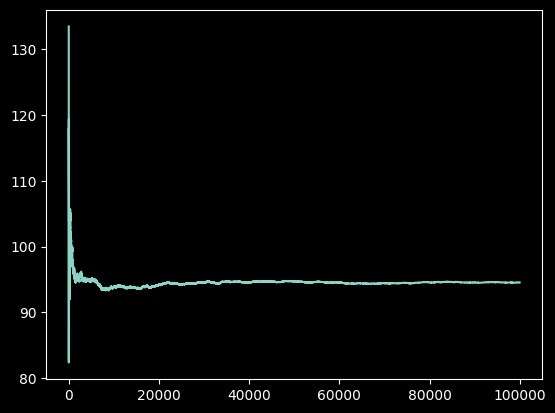

In [ ]:
@jit(nopython = True)
def graf(l, p=1):
  ls = []
  for i in range(1,n):
    a = np.array(l[:i:p])
    ls.append(a.mean())

  return ls

ls = graf(l)

plt.plot(ls)
plt.show()

In [ ]:
print(f'Hay un {100 * l.count(radio)/len(l)}% de flechas que recorren {radio}m y no impactan con ningún arbol')

Hay un 0.0% de flechas que recorren 320m y no impactan con ningún arbol


7. Finalmente, repetimos el experimento varias veces para encontrar la media de medias muestrales, la cual será el valor más aproximado a la distancia media que recorrerá la flecha hasta chocar.

In [ ]:
def rep(R, ρ, r_dist, n = 10**2, n_rep = 10**2):
  l = []
  for i in range(n_rep):
    d = experimento(R, ρ, r_dist, n)
    D = np.array(d)
    l.append(D.mean())
  return l

In [ ]:
l = rep(radio, densidad, rd)

In [ ]:
print(np.mean(l))

94.93924791840494
